# KNN Classification CIFAR-10
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks. Such a situation is called multiclass classification in oppose to multilabel classification when each example may have multiple label.

## Import Necessary packages

In [2]:
from IPython.core.debugger import Pdb as pdb
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline


Set style for plotting

In [4]:
#sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

In [5]:
# Set a random seed for reproducibility
np.random.seed(42)

## Extract Data file


  * DOWNLOAD the image data from [HERE](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) 
  * PUT IT in the data folder insider a folder


In [6]:
 # Unarchive data

tar = tarfile.open("data/cifar-10-python.tar.gz", "r:gz")
tar.extractall("data")
tar.close()

## Open and Load Data

Data are stored as a memory dump with python dict object. It was created using pickle function. To read one should "unpickle" it.

In [7]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin1')
    fo.close()
    return dict

## Divide data into six batches

Data are also splitted in to 5 pieces for conveniece. Let's read them all and concatenate

In [8]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

Read test data. In this dataset train/test split is provided by authors of the dataset to be able to consistently evaluate solutions

In [11]:
data_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

In [12]:
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"]

## Data Preprocessing

In [13]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 50000
Test size: 10000


## Downsample test and train set for easy experimentation


Downsample the data by taking a random sample of 10% of train and test sets. This will allow us to do some experiments much more quickly.

In [14]:
subsample_rate = 0.1

In order to preserve the same quantity of ratio of classes, **stratification** option is used for sampling.
Let's randomly (with fixed initial seed for the sake of reproducibility) divide part of train data

In [15]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)

/opt/conda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [16]:
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

/opt/conda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
unique_train = np.unique(y_train, return_counts=True)
list(zip(np.array(classes)[unique_train[0]], unique_train[1]))

[('airplane', 500),
 ('automobile', 500),
 ('bird', 500),
 ('cat', 500),
 ('deer', 500),
 ('dog', 500),
 ('frog', 500),
 ('horse', 500),
 ('ship', 500),
 ('truck', 500)]

In [18]:
X_train[0].shape

(3072,)

In [19]:
def show_pic(x):
    plt.imshow(x.reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
    plt.axis("off")

In [20]:
classes_idx_examples = np.zeros(10, dtype=np.int)
for i in range(10):
    classes_idx_examples[i] = np.where(y_train == i)[0][0]

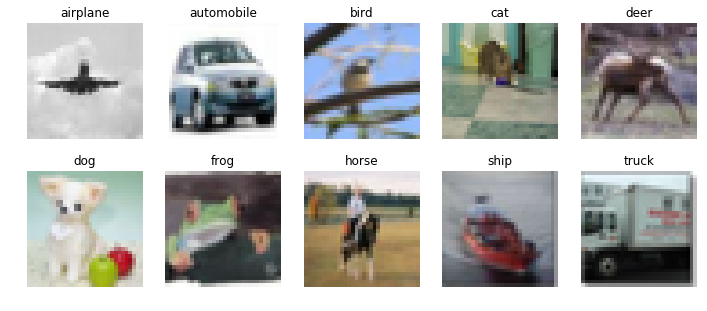

In [22]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_train[classes_idx_examples[i]])
    plt.title(classes[i])

In [21]:
results = pd.DataFrame(columns=["Model", "Test Accuracy", "Runtime(ms)"])

In [23]:
results

,Model,Test Accuracy,Runtime(ms)


## Classification using Logistic Regression

Let's compare KNN model to a model based on Multinomial Logistic Regression

Sklearn SGDClassifier with few options:

   * loss="log"− corresponds to Logistic Regression
   * penalty="none"− for now we don't want to use regularization (using it should impove quality by few percents)
   * max_iter=15− the number of passes over the training data (aka epochs)
   * average=10− by default Stochastic Gradient Descent method is used. This is due to the not very good approximation      of gradient (only by one example). To neglect this error we simply average gradient across last 10 steps.

In [28]:
import time
start = time.time()
duration =time.time()-start
model_lr_sklearn = SGDClassifier(loss="log", penalty="none", max_iter=15, average=10, n_jobs=-1)
model_lr_sklearn.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=10, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=15, n_iter=None,
       n_jobs=-1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

### Evalutaion
Prediction

In [29]:
y_pred_test = model_lr_sklearn.predict(X_test)

In [30]:
acc = accuracy_score(y_test, y_pred_test)
acc

0.325

In [32]:
results.loc[len(results)] = ["LR Sklearn", np.round(acc, 3), round(duration*1000,3) ]

## Classification Model using kNN_sklearn

In [33]:
model_knn_sklearn = KNeighborsClassifier(n_jobs=-1)

In [34]:
# fit the train set into model

start = time.time()
duration0 =time.time()-start
model_knn_sklearn.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

## Test Model on Test_set

In [35]:
y_pred_test = model_knn_sklearn.predict(X_test)

In [36]:
# Calculate accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(acc)

0.262


In [37]:
results.loc[len(results)] = ["KNN (Arbitary Sklearn)", np.round(acc, 3), round(duration0*1000,3)]

## Cross validation and k-Fold

In [38]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [39]:
## Baseline Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import time
knn = KNeighborsClassifier()
start = time.time()
knn_cv = cross_val_score(knn, X_train, y_train, cv=kfold, verbose= 5)
duration1 = time.time()-start
results.loc[len(results)] = ['KNN (default)', np.round(knn_cv.mean(),3), round(duration1)]

[CV]  ................................................................
[CV] .................................... , score=0.254, total=  22.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.9s remaining:    0.0s


[CV] .................................... , score=0.272, total=  22.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.4s remaining:    0.0s


[CV] .................................... , score=0.284, total=  22.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV] .................................... , score=0.286, total=  22.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s


[CV] .................................... , score=0.302, total=  24.2s
[CV]  ................................................................
[CV] .................................... , score=0.264, total=  21.7s
[CV]  ................................................................
[CV] .................................... , score=0.286, total=  23.2s
[CV]  ................................................................
[CV] .................................... , score=0.236, total=  21.5s
[CV]  ................................................................
[CV] .................................... , score=0.294, total=  21.6s
[CV]  ................................................................
[CV] .................................... , score=0.284, total=  22.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.8min finished


In [40]:
## Print results from baseline model 
results.loc[len(results)] = ['KNN (default)', np.round(knn_cv.mean(),3), round(duration1)]



## Hyperparameter tuning using GridSearch

In [28]:
from sklearn.neighbors import  KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
k_range = list(range(1, 6))
print(k_range)

[1, 2, 3, 4, 5]


In [29]:
# Parameter selection
p_range = list(range(1,3))
param_grid = dict(n_neighbors=k_range, p =p_range)
print(param_grid)

{'p': [1, 2], 'n_neighbors': [1, 2, 3, 4, 5]}


## Initiate Grid Search

In [30]:
best_model = GridSearchCV(knn, param_grid, cv=5, refit = True, scoring='accuracy', verbose=5, n_jobs=-1)
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] p=1, n_neighbors=1 ..............................................
[CV] .................. p=1, n_neighbors=1, score=0.302, total=  43.4s
[CV] p=1, n_neighbors=1 ..............................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   49.9s remaining:    0.0s


[CV] .................. p=1, n_neighbors=1, score=0.302, total=  41.9s
[CV] p=1, n_neighbors=1 ..............................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] .................. p=1, n_neighbors=1, score=0.287, total=  41.4s
[CV] p=1, n_neighbors=1 ..............................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV] .................. p=1, n_neighbors=1, score=0.274, total=  43.4s
[CV] p=1, n_neighbors=1 ..............................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.3min remaining:    0.0s


[CV] .................. p=1, n_neighbors=1, score=0.285, total=  47.3s
[CV] p=2, n_neighbors=1 ..............................................
[CV] .................. p=2, n_neighbors=1, score=0.284, total=  49.2s
[CV] p=2, n_neighbors=1 ..............................................
[CV] .................. p=2, n_neighbors=1, score=0.295, total=  48.7s
[CV] p=2, n_neighbors=1 ..............................................
[CV] .................. p=2, n_neighbors=1, score=0.274, total=  48.7s
[CV] p=2, n_neighbors=1 ..............................................
[CV] .................. p=2, n_neighbors=1, score=0.269, total=  49.4s
[CV] p=2, n_neighbors=1 ..............................................
[CV] .................. p=2, n_neighbors=1, score=0.267, total=  48.3s
[CV] p=1, n_neighbors=2 ..............................................
[CV] .................. p=1, n_neighbors=2, score=0.273, total=  42.0s
[CV] p=1, n_neighbors=2 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 173.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'p': [1, 2], 'n_neighbors': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

## Save best model from GridSearch

In [ ]:
from sklearn.externals import joblib
joblib.dump(best_model, 'GSmodel.pkl')

## Reload Model


In [30]:
from sklearn.externals import joblib  
best_model = joblib.load('GSmodel.pkl') 

## Evaluate Model Using Best Estimators

In [31]:
knn = best_model.best_estimator_
start = time.time()
knn_cv = cross_val_score(knn, X_train, y_train, cv=kfold)
duration = time.time()-start

In [32]:
results.loc[len(results)] = ['KNN (grid search)', np.round(knn_cv.mean(),3), round(duration*1000, 3)]

In [33]:
best_p = best_model.best_params_["p"]
best_n = best_model.best_params_["n_neighbors"]
print(best_p)
print(best_n)

1
5


In [32]:
best_model.cv_results_

/opt/conda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([0.72402353, 0.79517589, 0.81742916, 0.76887598, 0.79880114,
        0.81181822, 0.68918967, 0.88188038, 0.79860711, 0.72295108]),
 'mean_score_time': array([42.75791564, 48.07296529, 48.19962239, 49.93134274, 45.59377375,
        57.67779193, 44.29446926, 46.0939178 , 51.63585567, 47.84672818]),
 'mean_test_score': array([0.29  , 0.2778, 0.2602, 0.2438, 0.2836, 0.2662, 0.296 , 0.2746,
        0.306 , 0.2724]),
 'mean_train_score': array([1.     , 1.     , 0.60035, 0.5983 , 0.5515 , 0.5325 , 0.51515,
        0.4943 , 0.48845, 0.4536 ]),
 'param_n_neighbors': masked_array(data=[1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_p': masked_array(data=[1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
 

In [33]:
best_model.grid_scores_

/opt/conda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.29000, std: 0.01075, params: {'p': 1, 'n_neighbors': 1},
 mean: 0.27780, std: 0.01042, params: {'p': 2, 'n_neighbors': 1},
 mean: 0.26020, std: 0.01028, params: {'p': 1, 'n_neighbors': 2},
 mean: 0.24380, std: 0.00652, params: {'p': 2, 'n_neighbors': 2},
 mean: 0.28360, std: 0.01693, params: {'p': 1, 'n_neighbors': 3},
 mean: 0.26620, std: 0.01206, params: {'p': 2, 'n_neighbors': 3},
 mean: 0.29600, std: 0.00994, params: {'p': 1, 'n_neighbors': 4},
 mean: 0.27460, std: 0.01139, params: {'p': 2, 'n_neighbors': 4},
 mean: 0.30600, std: 0.01340, params: {'p': 1, 'n_neighbors': 5},
 mean: 0.27240, std: 0.01415, params: {'p': 2, 'n_neighbors': 5}]

## Visualize mean test scores and best parameters

/opt/conda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


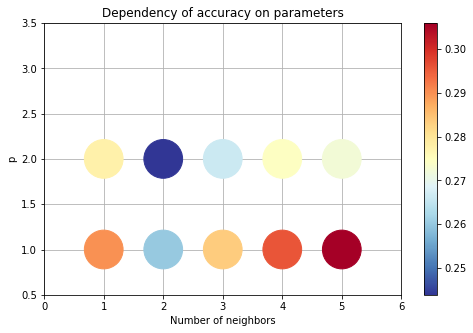

In [36]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(best_model.cv_results_["param_n_neighbors"], 
                 best_model.cv_results_["param_p"], 
                 c=best_model.cv_results_["mean_test_score"], 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid("on")
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5]);

In [83]:
knn = best_model.best_estimator_
start = time.time()
knn_cv = cross_val_score(knn, X_train, y_train, cv=kfold)
duration = time.time()-start

## Print mean Test Score for Best Model

In [47]:
best_model.cv_results_["mean_test_score"],

(array([0.29  , 0.2778, 0.2602, 0.2438, 0.2836, 0.2662, 0.296 , 0.2746,
        0.306 , 0.2724]),)

## Evaluate Model with best parameters using Test data

In [34]:
from sklearn.metrics import accuracy_score
knn = best_model.best_estimator_
start = time.time()
y_preds = knn.predict(X_test)
score = accuracy_score(y_test, y_preds)
duration2 = time.time()-start

In [35]:
score

0.286

## Print Results for Classification Model

In [36]:
results.loc[len(results)] = ['KNN (best model test)', score, round(duration*1000, 3)]


In [58]:
results

,Model,Test Accuracy,Runtime(ms)
0,KNN Arbitary Sklearn,0.262,56990.786
1,KNN Arbitary Sklearn,0.262,56990.786
2,KNN (grid search),0.315,56990.786
3,KNN (best model test),0.286,56990.786


# Weighted KNN


In [37]:
model_knn_weighted_sklearn = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=5)

In [41]:
model_knn_weighted_sklearn.fit(X_train, y_train)
Wduration = time.time()-start

In [39]:
y_pred_test = model_knn_weighted_sklearn.predict(X_test)

In [40]:
accuracy = accuracy_score(y_test, y_pred_test)
accuracy

0.299

In [42]:
results.loc[len(results)] = ["KNN Weighted Sklearn", np.round(accuracy, 3), round(Wduration*1000,3)]


## Grid Search on Weighted KNN

In [21]:
knn_weighted = KNeighborsClassifier(n_neighbors=5)
params = {'n_neighbors': list(range(1,6)),
          'weights': ['distance'],
          'p': list(range(1,3))}

In [22]:

weighted_knn_gs = GridSearchCV(knn_weighted, params, n_jobs=-1, cv=5, refit= True, verbose=5)
weighted_knn_gs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV]  n_neighbors=1, weights=distance, p=1, score=0.302, total=  42.0s
[CV] n_neighbors=1, weights=distance, p=1 ............................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   48.5s remaining:    0.0s


[CV]  n_neighbors=1, weights=distance, p=1, score=0.302, total=  40.8s
[CV] n_neighbors=1, weights=distance, p=1 ............................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV]  n_neighbors=1, weights=distance, p=1, score=0.287, total=  40.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV]  n_neighbors=1, weights=distance, p=1, score=0.274, total=  40.4s
[CV] n_neighbors=1, weights=distance, p=1 ............................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.2min remaining:    0.0s


[CV]  n_neighbors=1, weights=distance, p=1, score=0.285, total=  40.9s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV]  n_neighbors=1, weights=distance, p=2, score=0.284, total=  41.0s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV]  n_neighbors=1, weights=distance, p=2, score=0.295, total=  49.5s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV]  n_neighbors=1, weights=distance, p=2, score=0.274, total=  44.1s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV]  n_neighbors=1, weights=distance, p=2, score=0.269, total=  44.5s
[CV] n_neighbors=1, weights=distance, p=2 ............................
[CV]  n_neighbors=1, weights=distance, p=2, score=0.267, total=  50.2s
[CV] n_neighbors=2, weights=distance, p=1 ............................
[CV]  n_neighbors=2, weights=distance, p=1, score=0.302, total=  42.1s
[CV] n_neighbors=2, weights=distance, p=1 ............................
[CV]  

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 143.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [27]:
from sklearn.externals import joblib
joblib.dump(weighted_knn_gs, 'WeightedKNNGSmodel.pkl')

['WeightedKNNGSmodel.pkl']

In [47]:
## Reload saved model
from sklearn.externals import joblib  
weighted_knn_gs= joblib.load('WeightedKNNGSmodel.pkl') 

In [23]:
weighted_knn_gs.cv_results_

/opt/conda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([0.72638783, 0.66212354, 0.63975639, 0.60639648, 0.62311935,
        0.61396298, 0.61482944, 0.62376528, 0.62784963, 0.67423129]),
 'mean_score_time': array([40.10339079, 45.17692866, 40.17591295, 39.71863708, 40.00872183,
        39.88761349, 39.75558949, 39.7178628 , 39.65812507, 43.26408153]),
 'mean_test_score': array([0.29  , 0.2778, 0.29  , 0.2778, 0.3026, 0.2854, 0.3102, 0.2862,
        0.318 , 0.292 ]),
 'mean_train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'param_n_neighbors': masked_array(data=[1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_p': masked_array(data=[1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(

## Test Weighted KNN Grid Search Model on Test_data

In [48]:
import time
from sklearn.metrics import accuracy_score
knn1 = weighted_knn_gs.best_estimator_
start = time.time()
y_pred1 = knn1.predict(X_test)
weighted_score = accuracy_score(y_test, y_pred1)
duration3 = time.time()-start

In [49]:
weighted_score

0.299

In [51]:
results.loc[len(results)] = ["KNN Weighted(Gridsearch)", np.round(weighted_score, 3), round(duration3*1000,3)]

In [52]:
 weighted_knn_gs.cv_results_["mean_test_score"],

(array([0.29  , 0.2778, 0.29  , 0.2778, 0.3026, 0.2854, 0.3102, 0.2862,
        0.318 , 0.292 ]),)

In [53]:
print(weighted_knn_gs.best_params_)


{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [54]:
weighted_best_p = weighted_knn_gs.best_params_["p"]
weighted_best_n = weighted_knn_gs.best_params_["n_neighbors"]
print(weighted_best_p)
print(weighted_best_n)

1
5


## Examine Model

In [55]:
print(weighted_knn_gs.best_score_)
print(weighted_knn_gs.best_params_)
print(weighted_knn_gs.best_estimator_)

0.318
{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='distance')


# Results


In [56]:
results

,Model,Test Accuracy,Runtime(ms)
0,KNN (Arbitary Sklearn),0.262,0.035
1,KNN (default),0.276,231.000
2,KNN (default),0.276,231.000
3,KNN (grid search),0.315,273973.531
4,KNN (best model test),0.286,273973.531
5,KNN Weighted Sklearn,0.299,315923.851
6,KNN Weighted(Gridsearch),0.299,60139.476


# Results and Best Model

 Based on the above  results table  KNN Grid search on train_set is more accurate, about 31 percent 
compared to other models. When testing this model on test_set the accuracy droped to about 28 percent.
For weighted KNN accuracy results are same that is 29.99 percent.
The best model here is the classification model that uses weighted KNN model as the accuracy is consistent in both train and test set.

For the first KNN classification using GridSearch p value is 2 as it took significantly long time for GridSearch process. But Grid Search with p_range(1, 4) has also been done but there was no significant change in accuracy.

For the GridSearch with weighted KNN p value is in range(1,4).
